In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats
import seaborn as sns
from scipy.linalg import sqrtm
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load data

In [3]:
reviews = pd.read_csv('reviews_en_polarity.csv')
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...,en,0.9626
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...,en,0.9061
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...,en,0.9663
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...,en,0.9267
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just mins walk from the Airp...,en,0.8658


In [4]:
df_rec = reviews[['reviewer_id', 'listing_id', 'polarity']]

In [5]:
df_rec.nunique()

reviewer_id    59623
listing_id      2756
polarity        4631
dtype: int64

In [8]:
df_rec

,reviewer_id,listing_id,polarity
0,4298113,1178162,0.9626
1,6452964,1178162,0.9061
2,6449554,1178162,0.9663
3,2215611,1178162,0.9267
4,6848427,1178162,0.8658
...,...,...,...
63738,66618882,7462268,0.8955
63739,40052513,7462268,0.9504
63740,77129134,7462268,0.9693
63741,15799803,7462268,0.9957


# Build recommendation engine

In [5]:
# create utility matrix

matrix = df_rec.pivot_table(index='reviewer_id', columns='listing_id', values='polarity')
matrix.head()

listing_id,3353,5506,6695,6976,8792,9273,9765,9824,9855,9857,...,14770708,14770892,14774426,14774868,14778561,14780153,14813006,14823724,14843050,14843783
reviewer_id,,,,,,,,,,,,,,,,,,,,,
143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# keep track of reviewers (users) and listings (items)

userrows = list(matrix.index)
users_index = {userrows[i]: i for i in range(len(userrows))}

itemcols = list(matrix.columns)
items_index = {itemcols[i]: i for i in range(len(itemcols))}

In [7]:
# build our SVD model, returns predicted polarity values for (user,item) pairs

def svd(train, k):
    """
    train: utility matrix of training data
    k: number of features to use from Sigma matrix
    """
    utilMat = np.array(train)
    
    # the nan or unavailable entries are masked
    mask = np.isnan(utilMat)
    masked_arr = np.ma.masked_array(utilMat, mask)
    item_means = np.mean(masked_arr, axis=0)
    
    # nan entries will replaced by the average rating for each item
    utilMat = masked_arr.filled(item_means)
    x = np.tile(item_means, (utilMat.shape[0],1))
    
    # we remove the per item average from all entries.
    # the above mentioned nan entries will be essentially zero now
    utilMat = utilMat - x
    
    # The magic happens here. U and V are user and item features
    U, s, V=np.linalg.svd(utilMat, full_matrices=False)
    
    s=np.diag(s)
    
    # we take only the k most significant features
    s=s[0:k,0:k]
    U=U[:,0:k]
    V=V[0:k,:]
    
    s_root=sqrtm(s)
    Usk=np.dot(U,s_root)
    skV=np.dot(s_root,V)
    UsV = np.dot(Usk, skV)
    UsV = UsV + x
    
    # usv: predicted matrix fact
    
    print("svd done")
    return UsV

In [ ]:
# alternative:
from scipy.sparse.linalg import svds

U, sigma, Vt = svds(R_demeaned, k = 50) #have to remove per item mean from all entries in utilMat

# that the Sigma$ returned is just the values instead of a diagonal matrix. 
# This is useful, but since I'm going to leverage matrix multiplication to get predictions 
# I'll convert it to the diagonal matrix form.
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

# https://heartbeat.fritz.ai/recommender-systems-with-python-part-iii-collaborative-filtering-singular-value-decomposition-5b5dcb3f242b

In [12]:
#no_of_features = [8,10,12,14,17]

#for k in no_of_features:

svdout = svd(matrix, k=8)

svd done


In [13]:
pred = [] #to store the predicted ratings
for i, row in df_rec.iterrows():
    user = row['reviewer_id']
    item = row['listing_id']
    
    try:
        u_index = users_index[user]
        if item in items_index:
            i_index = items_index[item]
            pred_rating = svdout[u_index, i_index]
        else:
            pred_rating = np.mean(svdout[u_index, :])
        pred.append(pred_rating)
        
    except:
        print('error with user', user, 'at index', i)

In [15]:
rmse = sqrt(mean_squared_error(df_rec['polarity'], pred))
print(rmse)

0.21339783653166997


**Hyperparam optimization**: `k`, the number of features into which each user and movie will be resolved into

Train SVD on a training set (utility matrix) and predict on testing set. Problem is how to split it, ie test data can't have unseen users or listings (cold start), also harder the less observations there are of a particular reviewer/listing.

In [39]:
# try more features

no_of_features = [70, 100, 120, 150]
rmse= []

for k in no_of_features:
    svdout = svd(matrix, k=k)
    
    pred = [] #to store the predicted ratings
    for i, row in df_rec.iterrows():
        user = row['reviewer_id']
        item = row['listing_id']

        try:
            u_index = users_index[user]
            if item in items_index:
                i_index = items_index[item]
                pred_rating = svdout[u_index, i_index]
            else:
                pred_rating = np.mean(svdout[u_index, :])
            pred.append(pred_rating)

        except:
            print('error with user', user, 'at index', i)

    rmse_i = sqrt(mean_squared_error(df_rec['polarity'], pred))
    rmse.append(rmse_i)
    
    print(k, rmse_i)

svd done
70 0.18237034891641787
svd done
100 0.17276148855751566
svd done
120 0.1674806007852554
svd done
150 0.15999950624744558


Ideally would cross-validate it against a separated subset of the data to check performance, but can't handle new data (ex new listings or users) so tbd

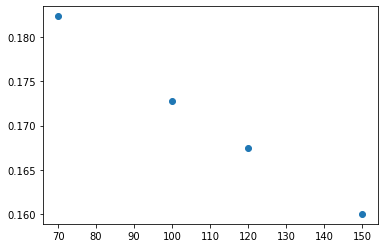

In [40]:
plt.scatter(no_of_features, rmse);

# Get top recommendations for a user

In [36]:
listing_id_array = df_rec['listing_id'].unique()

def get_recommendations(predMat, reviewer, N):
    """
    predMat: predicted matrix, svdout
    reviewer: selected reviewer_id
    N: top N recommendations
    
    return top N recommendations for specified user
    """
    user = df_rec['reviewer_id'][0]
    u_index = users_index[user]
    item_i = [items_index[listing_id_array[i]] for i in range(len(listing_id_array))]
    
    pred_user = [svdout[u_index, i_index] for i_index in item_i]
    
    d = {'listing_id': listing_id_array, 'predicted_polarity': pred_user}
    user_rec = pd.DataFrame(data=d)
    user_rec.sort_values(by=['predicted_polarity'], ascending=False, inplace=True)
    user_rec.reset_index(inplace=True, drop=True)
    
    return user_rec[:N]

In [38]:
user_rec = get_recommendations(svdout, df_rec['reviewer_id'][0], 10)
user_rec.style.bar(subset=['predicted_polarity'], align='mid', color=['#d65f5f', '#5fba7d'])

,listing_id,predicted_polarity
0,14813006,0.995900
1,12603280,0.993300
2,14760739,0.993300
3,5584915,0.992850
4,8481291,0.992800
5,12699603,0.992800
6,13655073,0.992100
7,14220964,0.991700
8,7841193,0.991700
9,5719606,0.991700
